In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import pickle
import datetime, time
from tqdm import tqdm_notebook as tqdm


from sklearn import preprocessing

%matplotlib inline

In [9]:
def autocorrelation(data, k):
    """Returns the autocorrelation of the *k*th lag in a time series data.

    Parameters
    ----------
    data : one dimentional numpy array
    k : the *k*th lag in the time series data (indexing starts at 0)
    """

    # yの平均
    y_avg = np.mean(data)

    # 分子の計算
    sum_of_covariance = 0
    for i in range(k+1, len(data)):
        covariance = ( data[i] - y_avg ) * ( data[i-(k+1)] - y_avg )
        sum_of_covariance += covariance

    # 分母の計算
    sum_of_denominator = 0
    for u in range(len(data)):
        denominator = ( data[u] - y_avg )**2
        sum_of_denominator += denominator

    return sum_of_covariance / sum_of_denominator

In [2]:
path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'
#path = '/Users/abcdm/Downloads/m5-forecasting-accuracy/'
#path = '../input/m5-forecasting-accuracy/'

In [3]:
%%time
train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')

CPU times: user 12.5 s, sys: 1.37 s, total: 13.9 s
Wall time: 14 s


In [4]:
sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
sell_prices_data = sell_prices_df[sell_prices_df.wm_yr_wk.isin(calendar_df.wm_yr_wk.unique())]
sell_prices_data.reset_index(drop=True, inplace=True)
tmp = sell_prices_data.groupby(['id'])[['wm_yr_wk', 'sell_price']].apply(lambda x: x.set_index('wm_yr_wk')['sell_price'].to_dict()).to_dict()
d = calendar_df.d
wm_yr_wk = calendar_df.wm_yr_wk
price_data = {}
for col in tqdm(train_df.id.unique()):
    price_data[col] = wm_yr_wk.map(tmp[col])
price_data = pd.DataFrame(price_data)
price_data.index = d
is_sell = price_data.notnull().astype(float).T
price_data = price_data.fillna(0)    

In [5]:
d_cols = train_df.columns[train_df.columns.str.startswith('d_')].values.tolist()

In [6]:
calendar_df['date']=pd.to_datetime(calendar_df.date)

In [7]:
is_sell.index=train_df.id
train_df.index=train_df.id
is_sell = pd.concat([
    train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']], is_sell
], axis=1)

In [8]:
df = train_df.T
item_id = train_df.id.values
df.loc[d_cols] = df.loc[d_cols].astype(int)
df.columns = df.loc['id', :]
df.reset_index(inplace=True)
df.index = df['index']
calendar_dict = calendar_df.set_index('d').to_dict()
for key, value in calendar_dict.items():
    df[key] = df['index'].map(value)
df.drop('index', axis=1, inplace=True)

In [10]:
train_df.index = train_df.id

In [42]:
std  = (is_sell.replace(0, np.nan).replace(1,0)[d_cols]+train_df[d_cols]).std(1)
mean  = (is_sell.replace(0, np.nan).replace(1,0)[d_cols]+train_df[d_cols]).mean(1)
mean = np.log(mean)
std = np.log(std)

price_mean =np.log( price_data.replace(0, np.nan)).mean(0)
price_std =np.log( price_data.replace(0, np.nan)).std(0)

In [43]:
data = pd.concat([
    mean, std, price_mean, price_std
], axis=1)

In [44]:
data.columns=['sell_mean', 'sell_std', 'price_mean', 'price_std']

In [46]:
data.head()

,sell_mean,sell_std,price_mean,price_std
id,,,,
HOBBIES_1_001_CA_1_validation,-0.527683,-0.163912,2.114327,1.710498e-02
HOBBIES_1_002_CA_1_validation,-1.279919,-0.533271,1.378766,2.309895e-14
HOBBIES_1_003_CA_1_validation,-1.039000,-0.362059,1.088562,1.177513e-14
HOBBIES_1_004_CA_1_validation,0.560072,0.690300,1.509796,3.232886e-02
HOBBIES_1_005_CA_1_validation,0.026303,0.270632,1.077382,5.363418e-02


In [47]:
item_id = train_df[train_df.dept_id=='FOODS_3'].id.unique()

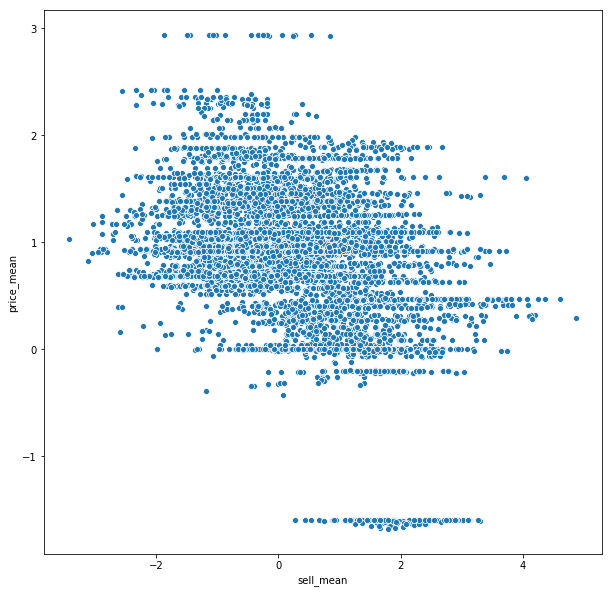

In [48]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data.loc[item_id], x='sell_mean', y='price_mean')

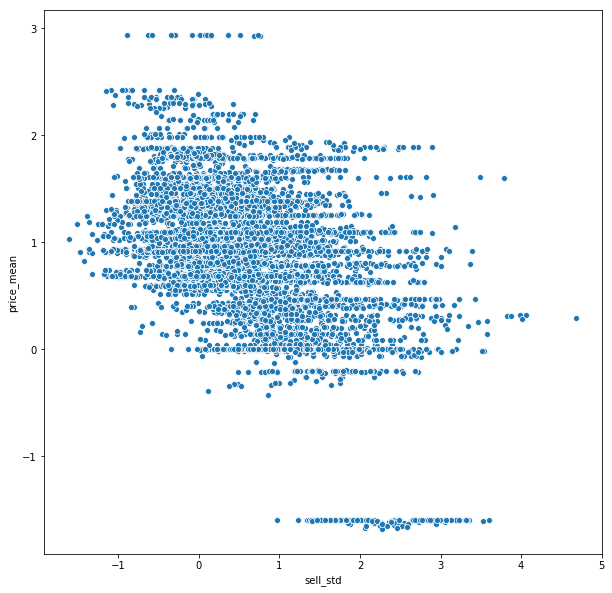

In [49]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data.loc[item_id], x='sell_std', y='price_mean')

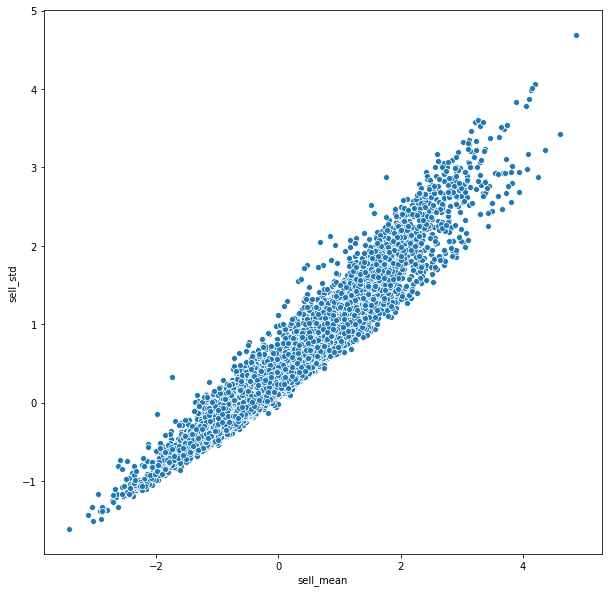

In [51]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data.loc[item_id], x='sell_mean', y='sell_std')

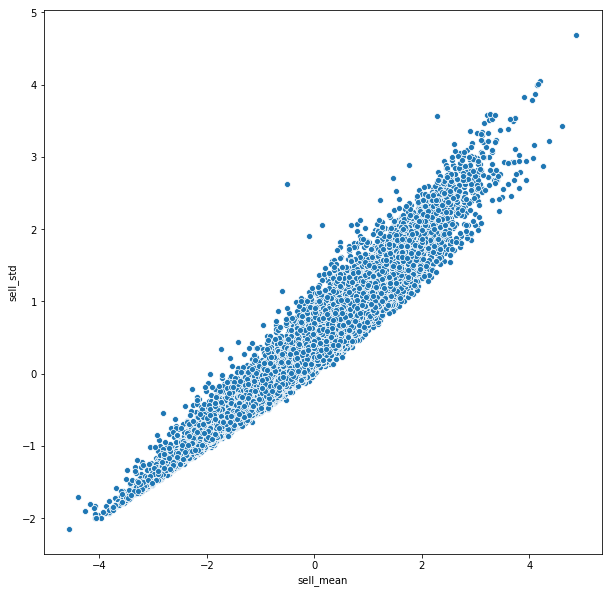

In [53]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data, x='sell_mean', y='sell_std')

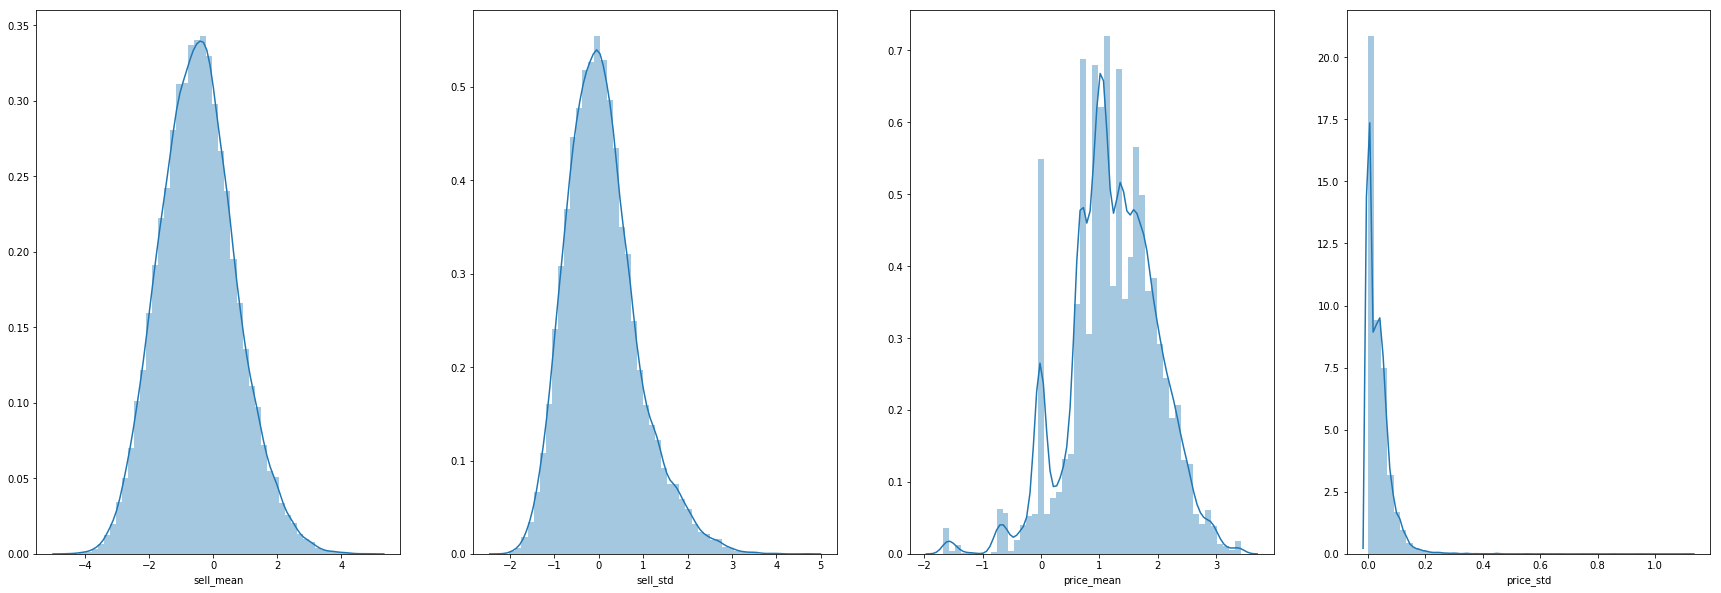

In [59]:
plt.figure(figsize=(30,10))
plt.subplot(1,4,1)
sns.distplot(data.sell_mean)
plt.subplot(1,4,2)
sns.distplot(data.sell_std)
plt.subplot(1,4,3)
sns.distplot(data.price_mean)
plt.subplot(1,4,4)
sns.distplot(data.price_std)

In [66]:
for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    d = train_df[col].to_dict()
    data[col] = data.index.map(d)

In [104]:
data.dept_id.value_counts()

FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64

In [105]:
data2 = data.groupby(['dept_id'])[['sell_mean', 'price_mean']].corr()

In [106]:
data2 = data2.reset_index()

In [108]:
data2.index= data2.dept_id

In [110]:
data2 =data2[data2.duplicated('dept_id')][['sell_mean']]

In [111]:
data2_index = data2.sort_values('sell_mean').dropna().index

In [116]:
data2.T

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
sell_mean,-0.49453,-0.394523,-0.354798,-0.446514,-0.275155,-0.462976,-0.365928


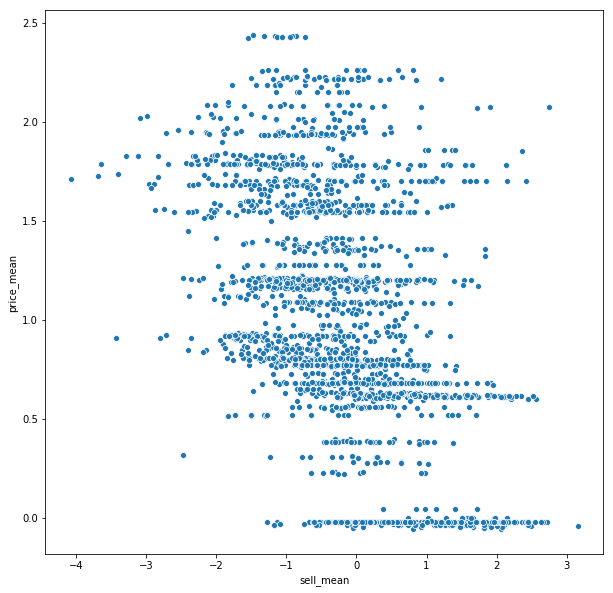

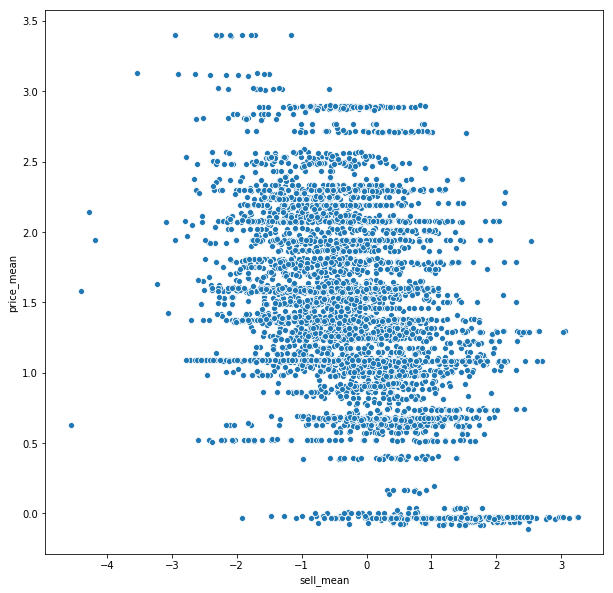

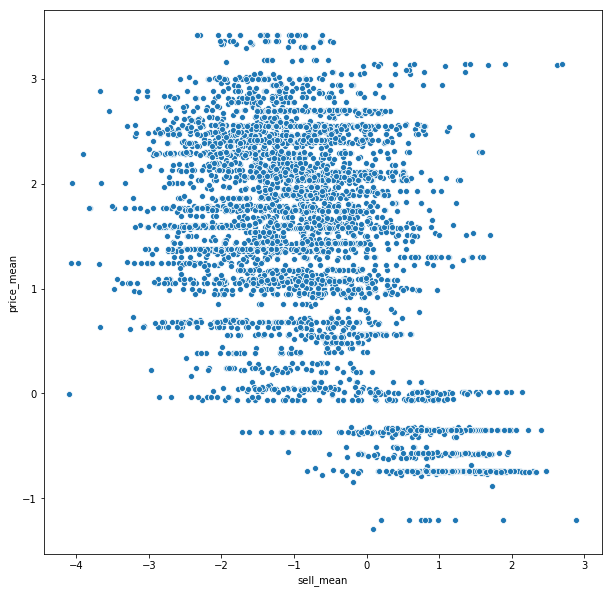

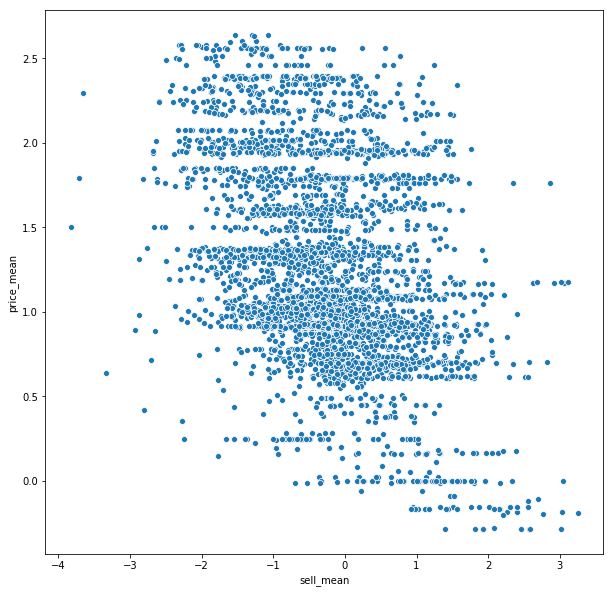

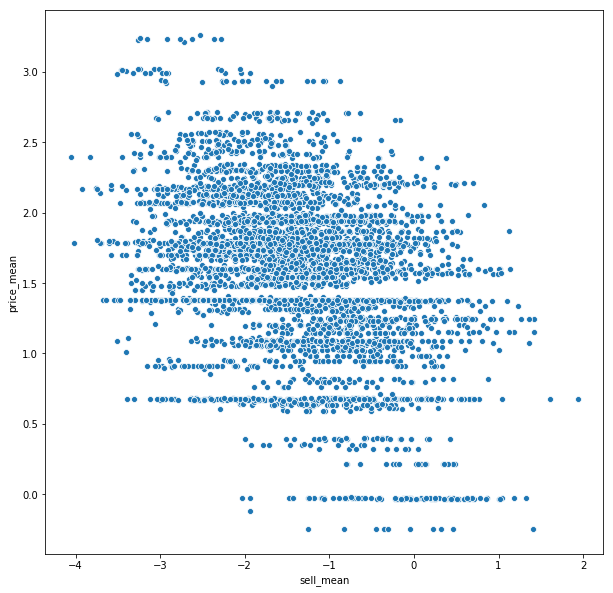

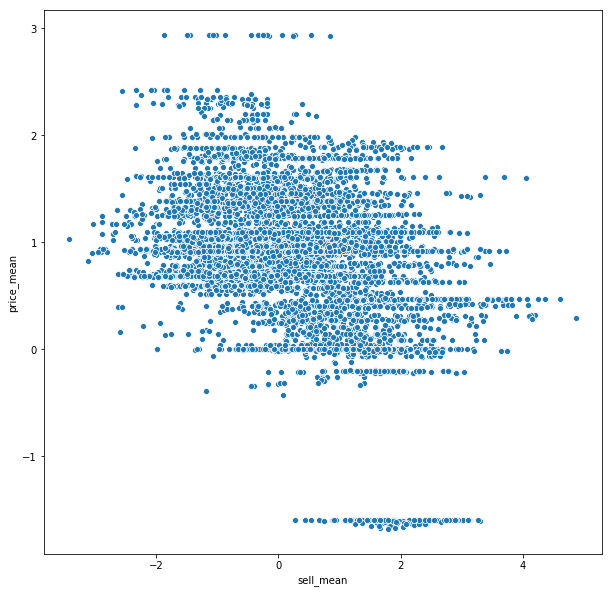

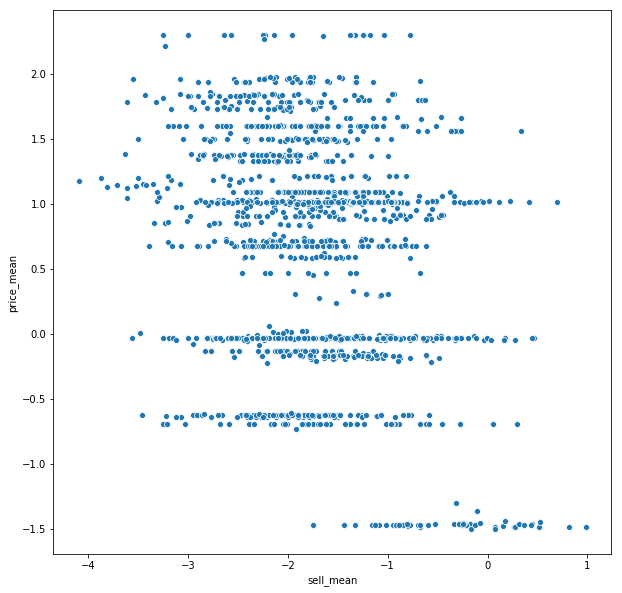

In [114]:
for indx in data2_index:
    item_id = train_df[train_df.dept_id==indx].id.unique()
    plt.figure(figsize=(10,10))
    sns.scatterplot(data=data.loc[item_id], x='sell_mean', y='price_mean')
    plt.show()

In [128]:
a = is_sell[d_cols].T.astype(int).replace(0, np.nan).replace(1, 0)

In [ ]:
df.loc[d_cols][is_sell==0]=np.nan

In [133]:
df2 = df.loc[d_cols][a.columns]+a

In [139]:
df2 = pd.concat([
    df2, df.loc[d_cols][['wday', 'month', 'year']]
], axis=1)

In [144]:
a = train_df.id.unique()

In [ ]:
gc.collect()

In [145]:
df2.groupby(['wday'])[a].mean()

DataError: No numeric types to aggregate

In [148]:
df2[a].info()#.groupby(['wday'])[a]

<class 'pandas.core.frame.DataFrame'>
Index: 1913 entries, d_1 to d_1913
Columns: 30490 entries, HOBBIES_1_001_CA_1_validation to FOODS_3_827_WI_3_validation
dtypes: object(30490)
memory usage: 445.0+ MB
